# Exercise 3 - Part A: eQTL Analysis

### - Chosen datasets: ```Blood stem cell (GSE18067)```, ```Erythroid (GSE18067)```

####  Import libraries

In [ ]:
import GEOparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Load the dataset

In [ ]:
gse = GEOparse.get_GEO(geo="GSE18067", destdir="data/")

#### Inspect the dataset

In [3]:
print("GSM example:")
for gsm_name, gsm in gse.gsms.items():
    print("Name: ", gsm_name)
    print("Metadata:",)
    for key, value in gsm.metadata.items():
        print(" - %s : %s" % (key, ", ".join(value)))
    print ("Table data:",)
    print (gsm.table.head())
    break

print()
print("GPL example:")
for gpl_name, gpl in gse.gpls.items():
    print("Name: ", gpl_name)
    print("Metadata:",)
    for key, value in gpl.metadata.items():
        print(" - %s : %s" % (key, ", ".join(value)))
    print("Table data:",)
    print(gpl.table.head())
    break

GSM example:
Name:  GSM451699
Metadata:
 - title : BXD13 Myeloid batch1
 - geo_accession : GSM451699
 - status : Public on Sep 12 2009
 - submission_date : Sep 10 2009
 - last_update_date : Sep 11 2009
 - type : RNA
 - channel_count : 1
 - source_name_ch1 : Myeloid
 - organism_ch1 : Mus musculus
 - taxid_ch1 : 10090
 - characteristics_ch1 : mouse id: 13, bxd strain: 13, cell type: Gr1+, array batch: 1
 - molecule_ch1 : total RNA
 - extract_protocol_ch1 : Total RNA was isolated using the RNeasy Mini kit (Qiagen) in accordance with the manufacturer’s protocol.
 - label_ch1 : biotin
 - label_protocol_ch1 : Biotinylated cRNA was prepared using the Illumina TotalPrep RNA Amplification Kit (Ambion) according to the manufacturer’s specifications starting with 100 ng total RNA
 - hyb_protocol : Standard Illumina hybridization protocol
 - scan_protocol : Standard Illumina scanning protocol
 - description : none
 - data_processing : Quantile normalization was applied on log2 transformed data.
 -

#### Extract expression data and annotate

In [4]:
def parse_gse(raw_gse):
    """
    gets GSE data, and parses it into a Dataframe.
    """
        
    final_df = pd.DataFrame(columns=["GSM_name", "ID_REF", "VALUE"])
    sample_dfs = []
    
    # Iterate through each sample
    for gsm_name, gsm in raw_gse.gsms.items():
        title = gsm.metadata['title'][0]
        strain = title.split(' ')[0]
        cell_type = title.split(' ')[1]
        batch = title.split(' ')[-1]
        if len(title.split(' ')) >= 4:   # there's a technical replicate
            technical_rep = title.split(' ')[-2]
        else:
            technical_rep = None
                    
        sample_data = {
            "GSM_name": gsm_name,
            "ID_REF": gsm.table["ID_REF"],
            "STRAIN": strain,
            "CELL_TYPE": cell_type,
            "BATCH": batch,
            "TECH_REP": technical_rep,
            "VALUE": gsm.table["VALUE"],
        }
        sample_df = pd.DataFrame(sample_data)
        sample_dfs.append(sample_df)
        
    final_df = pd.concat(sample_dfs, ignore_index=True)
    gene_identifiers = pd.DataFrame(gse.gpls[list(gse.gpls.keys())[0]].table)[["ID", "Symbol"]]
    return final_df, gene_identifiers


def annotate_gse_data(gse_data: pd.DataFrame, gene_id: pd.DataFrame):
    """
    gets parsed GSE data and gene identifiers DFs, along with a path to MGI coordinates file
    :return: a DataFrame of gse data merged with gene annotation
    """
    
    # merge with gene identifiers
    merged_gse = gse_data.merge(gene_id, left_on='ID_REF', right_on='ID')
    
    # drop duplicated columns originated from merging
    merged_gse = merged_gse.drop('ID', axis=1)

    # remove rows lacking gene identifiers
    merged_gse = merged_gse.dropna(axis=0, subset=["ID_REF" , "Symbol"])
    
    return merged_gse


parsed_gse, gene_ids = parse_gse(gse)
annotated_gse = annotate_gse_data(parsed_gse, gene_ids)
annotated_gse

,GSM_name,ID_REF,STRAIN,CELL_TYPE,BATCH,TECH_REP,VALUE,Symbol
19,GSM451699,18S_rRNA_X00686_523-S,BXD13,Myeloid,batch1,None,13.050935,Pigt
323,GSM451699,GI_10304988-S,BXD13,Myeloid,batch1,None,6.839661,St6galnac3
324,GSM451699,GI_10946639-S,BXD13,Myeloid,batch1,None,8.162534,Rangnrf
325,GSM451699,GI_11079652-S,BXD13,Myeloid,batch1,None,6.424202,L1cam
326,GSM451699,GI_11276064-S,BXD13,Myeloid,batch1,None,6.539623,Cyp2e1
...,...,...,...,...,...,...,...,...
4662746,GSM451798,TRAV12D-2_X04332_T_cell_receptor_alpha_variabl...,BXD21B,Progenitor,batch3,TechnicalRep2,6.379666,LOC382141
4662755,GSM451798,TRAV6-2_AF259071_T_cell_receptor_alpha_variabl...,BXD21B,Progenitor,batch3,TechnicalRep2,6.470300,LOC193543
4662761,GSM451798,TRAV9-3_U31878_T_cell_receptor_alpha_variable_...,BXD21B,Progenitor,batch3,TechnicalRep2,6.742396,A430107P09Rik
4662763,GSM451798,TRAV9D-2_U31877_T_cell_receptor_alpha_variable...,BXD21B,Progenitor,batch3,TechnicalRep2,6.707487,LOC195285


### Data Preprocessing

#### Define the cell types for the analysis
The variable ```cell_types``` should be a list containing two of the following: ```['Progenitor', 'Stem', 'Erythroid', 'Myeloid']```

In [5]:
cell_types = ["Stem", "Erythroid"]

# get expression data for the desired cell types
annotated_gse = annotated_gse.loc[annotated_gse['CELL_TYPE'].isin(cell_types)]
annotated_gse.to_csv(f'output/step0_annotated_gse.csv')
annotated_gse

,GSM_name,ID_REF,STRAIN,CELL_TYPE,BATCH,TECH_REP,VALUE,Symbol
46647,GSM451700,18S_rRNA_X00686_523-S,BXD23,Erythroid,batch1,None,14.969856,Pigt
46951,GSM451700,GI_10304988-S,BXD23,Erythroid,batch1,None,6.933870,St6galnac3
46952,GSM451700,GI_10946639-S,BXD23,Erythroid,batch1,None,9.098950,Rangnrf
46953,GSM451700,GI_11079652-S,BXD23,Erythroid,batch1,None,6.857034,L1cam
46954,GSM451700,GI_11276064-S,BXD23,Erythroid,batch1,None,6.551860,Cyp2e1
...,...,...,...,...,...,...,...,...
4569490,GSM451796,TRAV12D-2_X04332_T_cell_receptor_alpha_variabl...,BXD14,Erythroid,batch3,None,6.587475,LOC382141
4569499,GSM451796,TRAV6-2_AF259071_T_cell_receptor_alpha_variabl...,BXD14,Erythroid,batch3,None,6.276765,LOC193543
4569505,GSM451796,TRAV9-3_U31878_T_cell_receptor_alpha_variable_...,BXD14,Erythroid,batch3,None,6.871025,A430107P09Rik
4569507,GSM451796,TRAV9D-2_U31877_T_cell_receptor_alpha_variable...,BXD14,Erythroid,batch3,None,6.830468,LOC195285


#### Handle replicates
Average expression values across technical replicates, and across batch replicates.

In [6]:
def handle_reps(annotated_gse: pd.DataFrame):
    """
    gets annotated GSE DF, and averages values across replicates.
    replicates are cases where there are TechnicalRep1 & TechnicalRep2 OR cases where multiple values exist for a specific STRAIN and CELL_TYPE (due to batch differences).
    :return: a GSE DataFrame with averaged data for replicates
    """
    grouped_gse = annotated_gse.groupby(["ID_REF", "Symbol", "STRAIN", "CELL_TYPE"]).agg({"VALUE": "mean"}).reset_index()
    return grouped_gse

gse_no_reps = handle_reps(annotated_gse)
gse_no_reps.to_csv(f'output/step1_annotated_gse_no_replicates.csv')
gse_no_reps

,ID_REF,Symbol,STRAIN,CELL_TYPE,VALUE
0,18S_rRNA_X00686_523-S,Pigt,BXD1,Erythroid,15.261489
1,18S_rRNA_X00686_523-S,Pigt,BXD1,Stem,14.898029
2,18S_rRNA_X00686_523-S,Pigt,BXD11,Stem,14.877611
3,18S_rRNA_X00686_523-S,Pigt,BXD12,Erythroid,15.599339
4,18S_rRNA_X00686_523-S,Pigt,BXD12,Stem,14.472226
...,...,...,...,...,...
2110154,scl998.1.1_282-S,Olfr459,BXD6,Stem,6.466221
2110155,scl998.1.1_282-S,Olfr459,BXD8,Erythroid,6.629843
2110156,scl998.1.1_282-S,Olfr459,BXD8,Stem,6.609615
2110157,scl998.1.1_282-S,Olfr459,BXD9,Erythroid,6.493458


#### Create expression matrices for each cell type

In [7]:
def create_expression_matrices(annotated_gse: pd.DataFrame):
    """
    gets annotated GSE DF, and creates expression matrices for each CELL_TYPE.
    :return: a dictionary of expression matrices, where keys are CELL_TYPE values
    """
    
    expression_matrices = {}
    cell_types = annotated_gse["CELL_TYPE"].unique()
    
    for cell_type in cell_types:
        # filter the dataframe for the current CELL_TYPE
        df_filtered = annotated_gse[annotated_gse["CELL_TYPE"] == cell_type]
        
        # pivot the filtered dataframe to create the expression matrix
        expression_matrix = df_filtered.pivot_table(
            index=["ID_REF", "Symbol"],  # Rows will be the ID_REF and Symbol
            columns="STRAIN",            # Columns will be the STRAIN
            values="VALUE"               # Values will be the expression values from the VALUE column
        )
        
        # save & store the expression matrix in the dictionary
        expression_matrix.to_csv(f'output/step2_{cell_type.lower()}_expression_data.csv')
        expression_matrices[cell_type] = expression_matrix
        print(f"Shape of the {cell_type} cells' expression matrix: ", expression_matrix.shape)
    
    return expression_matrices


expression_mtxs = create_expression_matrices(gse_no_reps)
# expression matrices are saved in the function

Shape of the Erythroid cells' expression matrix:  (44897, 22)
Shape of the Stem cells' expression matrix:  (44897, 25)


#### Preprocess the genotype data

In [8]:
def get_unique_genotypes(genotype_data: pd.DataFrame):
    """
    gets genotypes DataFrame, and removes consecutive duplicate rows.
    :return: a DataFrame containing only unique genotypes
    """
    
    # find duplicates based on the BXD strain columns, ignoring the 'Locus', and 'Build37_position' columns
    bxd_columns = [genotype_data.columns[1],*genotype_data.columns[3:]]     # choose only chromosome and genotypes, assuming the strain data starts at the fourth column

    # remove consecutive duplicate rows
    unique_genotypes = genotype_data[(genotype_data[bxd_columns].shift(0) != genotype_data[bxd_columns].shift(1)).apply(np.any, axis=1)]
    
    return unique_genotypes


def get_genotype_position(genotype_data: pd.DataFrame):
    """
    Gets genotypes DataFrame, calculates the total genome absolute position map and assigns each locus it's absolute position within it
    :return: genotypes DF with absolute position within the genome, and a list with the cumulative length of chromosomes to calculate absolute position
    """
    
    loci_group = genotype_data.groupby(['Chr_Build37'])
    chr_length = [0]
    for num, (name, group) in enumerate(loci_group):
        chr_length.append(chr_length[-1] + max(group['Build37_position']))
    genotype_data = genotype_data.join(pd.DataFrame(columns=['absolute_locus_position'], 
                                                    data=genotype_data['Chr_Build37'].apply(lambda x: chr_length[x-1]) + genotype_data['Build37_position']))
    return genotype_data, chr_length


# load genotype data
genotypes = pd.read_excel('data/genotypes.xls', skiprows=1, index_col=0, header=0)

# preprocess
unique_genotypes = get_unique_genotypes(genotypes)
unique_genotypes, chr_length = get_genotype_position(unique_genotypes)

# organize the data by absolute locus position
unique_genotypes = unique_genotypes.sort_values(by='absolute_locus_position')
# reorganize the columns
unique_genotypes = unique_genotypes[['Locus', 'Chr_Build37', 'Build37_position', 'absolute_locus_position', *unique_genotypes.columns[3:-1]]]

unique_genotypes.set_index("Locus", inplace=True)

# save
unique_genotypes.to_csv('output/step3_unique_genotypes.csv')
unique_genotypes

,Chr_Build37,Build37_position,absolute_locus_position,BXD1,BXD2,BXD5,BXD6,BXD8,BXD9,BXD11,...,BXD94,BXD95,BXD96,BXD97,BXD98,BXD99,BXD100,BXD101,BXD102,BXD103
Locus,,,,,,,,,,,,,,,,,,,,,
rs6269442,1,3482276,3482276,B,B,D,D,D,B,B,...,D,D,B,B,B,B,B,U,U,U
rs6376963,1,5008090,5008090,B,B,D,D,D,B,B,...,D,D,B,B,B,B,B,U,U,U
rs3677817,1,5176059,5176059,B,B,D,D,D,B,B,...,D,D,B,B,B,B,B,U,U,U
rs8236463,1,5579194,5579194,B,B,D,D,D,B,D,...,D,D,B,B,B,B,B,U,U,U
rs6298633,1,6820242,6820242,B,B,D,D,D,B,D,...,D,D,B,B,B,B,B,U,U,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CEL-X_154048891,20,160516970,2610873493,B,B,B,B,B,B,B,...,D,H,B,B,D,D,B,U,U,U
CEL-X_154259201,20,160727280,2611083803,B,B,B,D,B,B,B,...,D,H,B,B,D,D,B,U,U,U
rs3657281,20,160951100,2611307623,B,B,B,D,B,B,B,...,D,H,B,B,D,D,B,U,U,U


#### Decide on preprocessing thresholds
maximal value and variance minimal thresholds will be decided based on the data

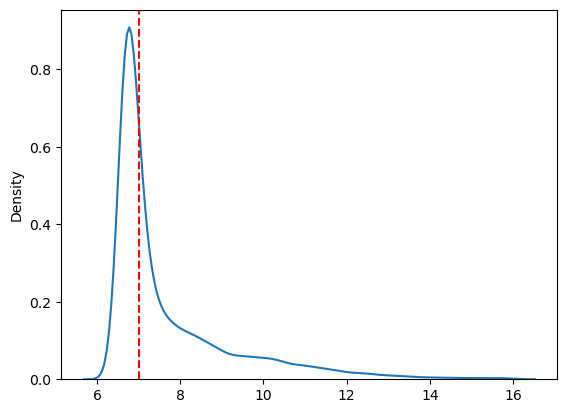

In [9]:
sns.kdeplot(expression_mtxs["Erythroid"].max(axis=1))
plt.axvline(x=7, color='red', linestyle='--')

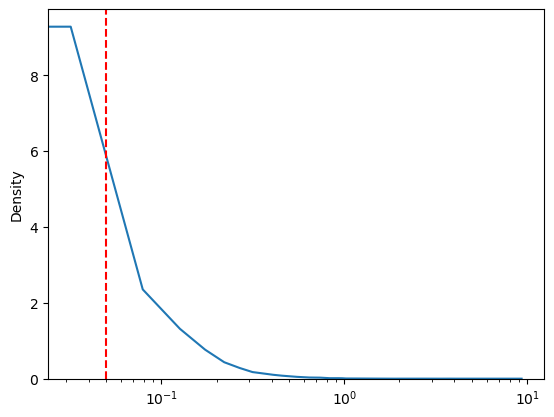

In [10]:
sns.kdeplot(expression_mtxs["Erythroid"].var(axis=1))
plt.axvline(x=0.05, color='red', linestyle='--')
plt.xscale('log')

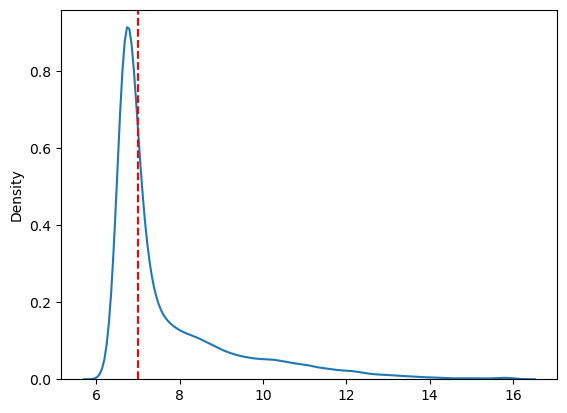

In [11]:
sns.kdeplot(expression_mtxs["Stem"].max(axis=1))
plt.axvline(x=7, color='red', linestyle='--')

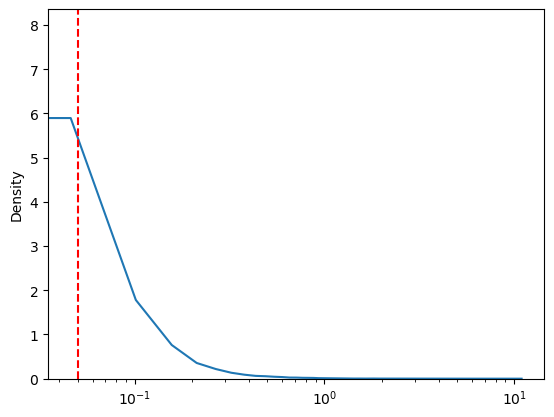

In [12]:
sns.kdeplot(expression_mtxs["Stem"].var(axis=1))
plt.axvline(x=0.05, color='red', linestyle='--')
plt.xscale('log')

In [13]:
# set preprocessing params
maximal_val_threshold = {"Erythroid": 7, "Stem": 7}
variance_threshold = {"Erythroid": 0.05, "Stem": 0.05}

#### Preprocess the expression data
Filter out genes with low maximal expression values, and genes with low variance.
Handle multiple probes of the same gene by keeping the one with the highest variance, and use only genes that are present in genotypes.xls.

In [14]:
def keep_highest_variance_probes(expression_mtx: pd.DataFrame):
    """
    gets an expression matrix, and keeps only the probe with the highest variance for each gene.
    :return: a DataFrame containing only the highest variance probes for each gene
    """
    # Calculate variance for each row
    expression_mtx['Variance'] = expression_mtx.var(axis=1)

    # Group by 'Symbol' and keep the row with the highest variance
    filtered_mtx = expression_mtx.loc[expression_mtx.groupby('Symbol')['Variance'].idxmax()]

    # Drop the 'Variance' column as it is no longer needed
    filtered_mtx = filtered_mtx.drop(columns='Variance')

    # Set the index to 'Symbol' only
    filtered_mtx = filtered_mtx.reset_index(level='ID_REF', drop=True)

    return filtered_mtx


def preprocess_data(expression_matrices: dict, genotypes: pd.DataFrame, maximal_val_thres: dict, variance_thres: dict):
    """
    gets expression matrices for each CELL_TYPE, and preprocesses the data.
    :return: a dictionary of preprocessed expression matrices, where keys are CELL_TYPE values
    """
    
    preprocessed_data = {}
    
    for cell_type, expression_data in expression_matrices.items():
        
        print(f"{cell_type}, unfiltered shape:", expression_data.shape)

        # remove rows with low maximal value
        filtered_data = expression_data[expression_data.max(axis=1) > maximal_val_thres[cell_type]]

        # remove rows with low variance
        filtered_data = filtered_data[filtered_data.var(axis=1) > variance_thres[cell_type]]
        
        # for multiple probes of the same gene, keep the one with the highest variance
        filtered_data = keep_highest_variance_probes(filtered_data)
        print(f"{cell_type}, filtered shape:", filtered_data.shape)

        # use only strains that are present in genotypes.xls
        common_strains = filtered_data.columns.intersection(genotypes.columns).tolist()
        filtered_data = filtered_data[common_strains].copy()
        print(f"{cell_type}, only strains present in genotypes shape:", filtered_data.shape)
        
        # save & store the processed dataset in the dictionary
        filtered_data.to_csv(f'output/step3_{cell_type.lower()}_preprocessed_expression_data.csv')
        preprocessed_data[cell_type] = filtered_data
    return preprocessed_data


# preprocess
processed_expression_mtxs = preprocess_data(expression_mtxs, unique_genotypes, maximal_val_threshold, variance_threshold)

Erythroid, unfiltered shape: (44897, 22)
Erythroid, filtered shape: (10884, 22)
Erythroid, only strains present in genotypes shape: (10884, 18)
Stem, unfiltered shape: (44897, 25)
Stem, filtered shape: (10307, 25)
Stem, only strains present in genotypes shape: (10307, 20)


### Association Test
The test was conducted by deploying the `ex3_conduct_eQTL.py` script, which is attached in the submission.

#### Data Visualization for sanity check
##### Erythroid cells


In [15]:
erythroid_results = pd.read_csv('output/step4_erythroid_association_test_results.csv', index_col=0)
erythroid_results

,rs6269442,rs6376963,rs3677817,rs8236463,rs6298633,rs6360236,D1Mit1,D1Mit294,rs3655978,rs3669485,...,DXMit10,CEL-X_143438541,CEL-X_143595976,rs13484097,gnfX.141.820,CEL-X_154048891,CEL-X_154259201,rs3657281,gnfX.146.867,DXMit223
Olfr688,0.908166,0.908166,0.908166,0.908166,0.908166,0.908166,0.908166,0.908166,0.908166,0.634130,...,0.995667,0.995727,0.995727,0.995727,0.561097,0.561097,0.400726,0.326749,0.326749,0.326749
Rabggta,0.903046,0.903046,0.903046,0.903046,0.903046,0.903046,0.903046,0.903046,0.903046,0.476111,...,0.436813,0.888411,0.888411,0.888411,0.153444,0.153444,0.500775,0.274342,0.274342,0.274342
Sms,0.055482,0.055482,0.055482,0.055482,0.055482,0.055482,0.055482,0.055482,0.055482,0.023172,...,0.099616,0.215372,0.215372,0.215372,0.839344,0.839344,0.930880,0.506514,0.506514,0.506514
A530065E19Rik,0.156795,0.156795,0.156795,0.156795,0.156795,0.156795,0.156795,0.156795,0.156795,0.047102,...,0.403293,0.317035,0.317035,0.317035,0.109395,0.109395,0.509569,0.902485,0.902485,0.902485
Ube2l3,0.692640,0.692640,0.692640,0.692640,0.692640,0.692640,0.692640,0.692640,0.692640,0.563511,...,0.486413,0.482937,0.482937,0.482937,0.463176,0.463176,0.491723,0.437480,0.437480,0.437480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9130020K20Rik,0.700023,0.700023,0.700023,0.700023,0.700023,0.700023,0.700023,0.700023,0.700023,0.230687,...,0.660908,0.564352,0.564352,0.564352,0.568479,0.568479,0.842330,0.667118,0.667118,0.667118
C130089M10Rik,0.707660,0.707660,0.707660,0.707660,0.707660,0.707660,0.707660,0.707660,0.707660,0.911352,...,0.355464,0.426992,0.426992,0.426992,0.326538,0.326538,0.496947,0.602185,0.602185,0.602185
4930402H24Rik,0.776241,0.776241,0.776241,0.776241,0.776241,0.776241,0.776241,0.776241,0.776241,0.309000,...,0.472984,0.866476,0.866476,0.866476,0.643192,0.643192,0.954635,0.984878,0.984878,0.984878
Cyp2a5,0.699980,0.699980,0.699980,0.699980,0.699980,0.699980,0.699980,0.699980,0.699980,0.654285,...,0.526398,0.283727,0.283727,0.283727,0.583509,0.583509,0.426038,0.637599,0.637599,0.637599


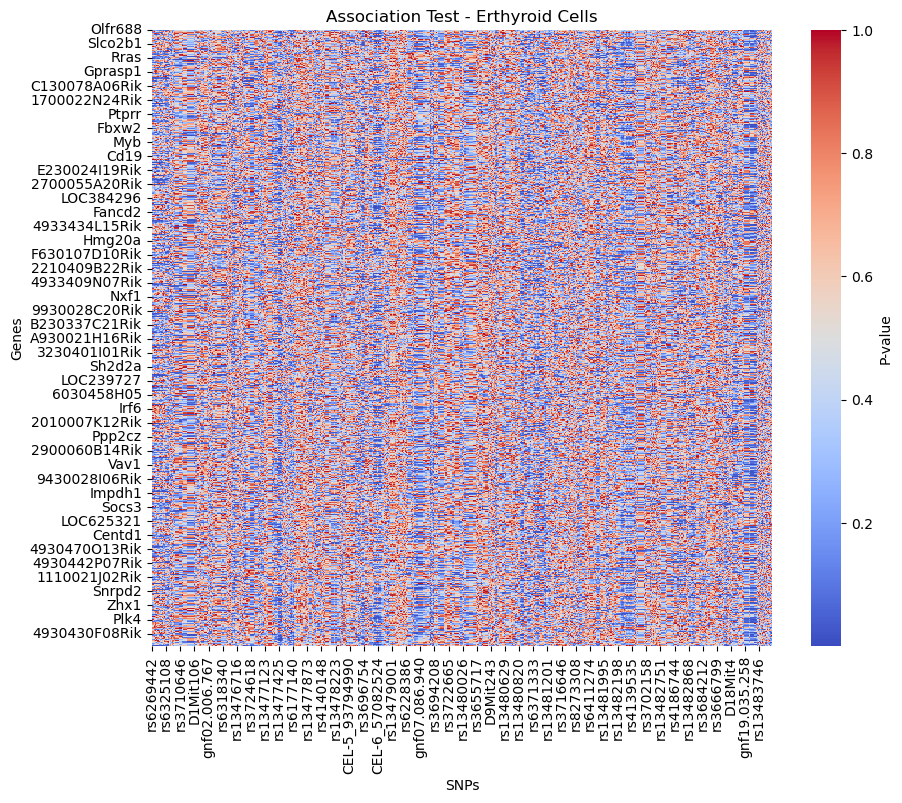

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(erythroid_results, cmap='coolwarm', cbar_kws={'label': 'P-value'})
plt.title('Association Test - Erthyroid Cells')
plt.xlabel('SNPs')
plt.ylabel('Genes')
plt.show()

##### Stem cells

In [ ]:
stem_cell_results = pd.read_csv('', index_col=0)
stem_cell_results

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(stem_cell_results, cmap='coolwarm', cbar_kws={'label': 'P-value'})
plt.title('Association Test - Stem Cells')
plt.xlabel('SNPs')
plt.ylabel('Genes')
plt.show()